In [1]:
import numpy as np
import xarray as xr
import os
import glob
from pathlib import Path 
import pathlib
from pprint import pprint
import matplotlib.pyplot as plt
import time
import requests
import s3fs
from os.path import dirname, join
import datetime
import myDate
import netCDF4

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings('ignore')

In [ ]:
alongtrack_file_dir = Path('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_nosicapplied/')
alongtrack_file_dir_randomnoise = Path('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_randomnoise_nosicapplied/')
alongtrack_file_dir_missingdata = Path('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_missingdata_nosicapplied/')
alongtrack_file_dir_orbiterror_2cm = Path('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_orbiterror_2cm_nosicapplied/')
alongtrack_file_dir_3errors_2cm = Path('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_3errors_2cm_nosicapplied/')
grids_file_dir = Path('/home/jovyan/Data/ECCO_GMSL/gridding_output_nosicapplied/')
grids_file_dir_randomnoise = Path('/home/jovyan/Data/ECCO_GMSL/gridding_output_randomnoise_nosicapplied/')
grids_file_dir_missingdata = Path('/home/jovyan/Data/ECCO_GMSL/gridding_output_missingdata_nosicapplied/')
grids_file_dir_orbiterror_2cm = Path('/home/jovyan/Data/ECCO_GMSL/gridding_output_orbiterror_2cm_nosicapplied/')
grids_file_dir_3errors_2cm = Path('/home/jovyan/Data/ECCO_GMSL/gridding_output_3errors_2cm_nosicapplied/')
main_dir = Path('/home/jovyan/ECCO_GMSL/')
output_dir = Path('/home/jovyan/Data/ECCO_GMSL/GMSL/')
fig_dir = Path('/home/jovyan/Figures/ECCO_GMSL/')

ecco_mean = xr.open_dataset(str(Path('/home/jovyan/Data/ECCO_GMSL')) + '/ECCO_V4r4_mean_SSH_nosicapplied.nc')
ecco_mean_all = xr.open_dataset(str(Path('/home/jovyan/Data/ECCO_GMSL')) + '/ECCO_V4r4_mean_SSH_alllatnosicapplied.nc')

# Compute GMSL from ECCO synthetic grids with simple weighing

### No error

In [3]:
# After running Kevin's code simple gridder.py, grids are generating
ECCO_grids_files = list(grids_file_dir.glob('*SSHA_gridded_*nc'))
ECCO_grids_files=np.sort(ECCO_grids_files)
print(ECCO_grids_files[0:5])
print('...')
print(ECCO_grids_files[-5:-1])

[PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_nosicapplied/SSHA_gridded_1992-09-27.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_nosicapplied/SSHA_gridded_1992-10-07.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_nosicapplied/SSHA_gridded_1992-10-17.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_nosicapplied/SSHA_gridded_1992-10-27.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_nosicapplied/SSHA_gridded_1992-11-06.nc')]
...
[PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_nosicapplied/SSHA_gridded_2017-11-25.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_nosicapplied/SSHA_gridded_2017-12-05.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_nosicapplied/SSHA_gridded_2017-12-15.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_nosicapplied/SSHA_gridded_2017-12-25.nc')]


In [4]:
grids = xr.open_mfdataset(
        paths=ECCO_grids_files,
        combine='nested',
        concat_dim='time',
        decode_cf=True,
        compat='override',
        coords='minimal',
        chunks={'time': 1}  
    )   
grids

<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 360, time: 924)
Coordinates:
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * latitude   (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time       (time) datetime64[ns] 1992-09-27 1992-10-07 ... 2018-01-04
Data variables:
    SSHA       (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    counts     (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    mask       (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes:
    gridding_method:  Gridded using pyresample resample_gauss with roi=600000...

In [5]:
grids=grids.where(np.array(grids.counts)>=100)

In [6]:
grids=grids.sel(latitude=slice(-66,66))
grids

<xarray.Dataset>
Dimensions:    (time: 924, latitude: 264, longitude: 720)
Coordinates:
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * latitude   (latitude) float32 -65.75 -65.25 -64.75 ... 64.75 65.25 65.75
  * time       (time) datetime64[ns] 1992-09-27 1992-10-07 ... 2018-01-04
Data variables:
    SSHA       (time, latitude, longitude) float32 dask.array<chunksize=(1, 264, 720), meta=np.ndarray>
    counts     (time, latitude, longitude) float32 dask.array<chunksize=(1, 264, 720), meta=np.ndarray>
    mask       (time, latitude, longitude) float32 dask.array<chunksize=(1, 264, 720), meta=np.ndarray>
Attributes:
    gridding_method:  Gridded using pyresample resample_gauss with roi=600000...

In [7]:
[LO,LA]=np.meshgrid(grids.longitude,grids.latitude)
weights = np.cos(np.deg2rad(LA))
weights=np.tile(weights, [grids.SSHA.shape[0], 1, 1])
weights[np.where(~np.isfinite(grids.SSHA))]=np.nan
ssh_weighted_mean=np.nansum(grids.SSHA*weights,axis=(1,2))/np.nansum(weights,axis=(1,2))

In [8]:
# make new DataArray objects
gmsl_grids = xr.DataArray(ssh_weighted_mean, dims=['time'])
gmsl_grids = gmsl_grids.assign_coords({'time':grids.time})
gmsl_grids.name = 'gmsl_grids'
gmsl_grids

<xarray.DataArray 'gmsl_grids' (time: 924)>
array([-3.35424878e-02, -3.15704942e-02, -2.97211539e-02, -3.01636010e-02,
       -3.12151089e-02, -3.31653394e-02, -3.13523225e-02, -3.28133032e-02,
       -3.32171395e-02, -3.89642678e-02, -4.09371518e-02, -4.06149812e-02,
       -4.10725400e-02, -4.25708964e-02, -4.29418050e-02, -4.00319248e-02,
       -3.97198014e-02, -3.81834544e-02, -4.08023484e-02, -3.87738608e-02,
       -3.80125158e-02, -3.72792259e-02, -3.85224000e-02, -3.85570079e-02,
       -3.71993519e-02, -3.69450487e-02, -3.79394032e-02, -3.74104530e-02,
       -3.90305296e-02, -3.77354510e-02, -3.65432948e-02, -3.73000205e-02,
       -3.46635245e-02, -3.37467901e-02, -3.22100073e-02, -3.20308581e-02,
       -3.04958392e-02, -2.84147058e-02, -2.76431981e-02, -2.76976041e-02,
       -2.94093434e-02, -3.01839449e-02, -3.28236297e-02, -3.20038199e-02,
       -2.84981038e-02, -2.69383211e-02, -3.16333100e-02, -3.23781297e-02,
       -3.04484572e-02, -3.41204852e-02, -3.82368490e-02, -3.93310115e-02,
       -3.51031087e-02, -3.32544148e-02, -3.21704932e-02, -3.33084464e-02,
       -3.17383409e-02, -3.33540998e-02, -3.32428813e-02, -3.63176242e-02,
       -3.59278508e-02, -3.55076827e-02, -3.85951065e-02, -3.94888073e-02,
       -4.01364155e-02, -3.90678607e-02, -3.73505242e-02, -3.68583165e-02,
       -3.56557406e-02, -3.55226286e-02, -3.19277383e-02, -3.21692564e-02,
       -2.96279062e-02, -2.96319500e-02, -2.67997812e-02, -2.76168641e-02,
       -2.54191849e-02, -2.63111517e-02, -2.77558900e-02, -2.83813346e-02,
...
        4.37458865e-02,  3.97428311e-02,  3.82923037e-02,  4.21097539e-02,
        4.14056778e-02,  3.79714593e-02,  3.84165794e-02,  3.66020799e-02,
        3.84920910e-02,  3.60000916e-02,  3.88026536e-02,  3.66407149e-02,
        3.77580263e-02,  3.71986590e-02,  3.92618664e-02,  3.86012867e-02,
        3.66206430e-02,  3.80331464e-02,  3.72664817e-02,  3.69350947e-02,
        3.71422283e-02,  3.65053974e-02,  3.54013294e-02,  3.87486592e-02,
        3.91535535e-02,  3.99635024e-02,  4.18622866e-02,  4.32719141e-02,
        4.24299762e-02,  4.22969982e-02,  4.37262245e-02,  4.64143194e-02,
        4.61615846e-02,  4.81634997e-02,  4.73340675e-02,  4.88049723e-02,
        4.68526110e-02,  4.66375165e-02,  4.47805263e-02,  4.50398512e-02,
        4.24686484e-02,  3.87021080e-02,  3.68108116e-02,  3.75178941e-02,
        3.73386666e-02,  3.78090888e-02,  3.77154872e-02,  3.77303623e-02,
        3.93507890e-02,  4.03331146e-02,  4.11640443e-02,  4.17089835e-02,
        3.98945399e-02,  3.98719832e-02,  4.25944999e-02,  4.12794501e-02,
        4.17962968e-02,  4.03562300e-02,  4.10734154e-02,  4.33004610e-02,
        4.41990681e-02,  4.67037037e-02,  4.71757129e-02,  4.78542522e-02,
        4.96560708e-02,  4.73886207e-02,  4.85190451e-02,  4.91735190e-02,
        5.22068068e-02,  5.36501966e-02,  5.42327762e-02,  5.65823540e-02,
        5.48892319e-02,  5.58058135e-02,  5.36121055e-02,  5.50906882e-02],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-09-27 1992-10-07 ... 2018-01-04

### Random noise

In [9]:
# After running Kevin's code simple gridder.py, grids are generating
ECCO_grids_files = list(grids_file_dir_randomnoise.glob('*SSHA_gridded_*nc'))
ECCO_grids_files=np.sort(ECCO_grids_files)
print(ECCO_grids_files[0:5])
print('...')
print(ECCO_grids_files[-5:-1])

[PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_randomnoise_nosicapplied/SSHA_gridded_1992-09-27.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_randomnoise_nosicapplied/SSHA_gridded_1992-10-07.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_randomnoise_nosicapplied/SSHA_gridded_1992-10-17.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_randomnoise_nosicapplied/SSHA_gridded_1992-10-27.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_randomnoise_nosicapplied/SSHA_gridded_1992-11-06.nc')]
...
[PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_randomnoise_nosicapplied/SSHA_gridded_2017-11-25.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_randomnoise_nosicapplied/SSHA_gridded_2017-12-05.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_randomnoise_nosicapplied/SSHA_gridded_2017-12-15.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_randomnoise_nosicapplied/SSHA_gridded_2017-12-25.nc')]


In [10]:
grids = xr.open_mfdataset(
        paths=ECCO_grids_files,
        combine='nested',
        concat_dim='time',
        decode_cf=True,
        compat='override',
        coords='minimal',
        chunks={'time': 1}  
    )   
grids

<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 360, time: 924)
Coordinates:
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * latitude   (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time       (time) datetime64[ns] 1992-09-27 1992-10-07 ... 2018-01-04
Data variables:
    SSHA       (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    counts     (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    mask       (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes:
    gridding_method:  Gridded using pyresample resample_gauss with roi=600000...

In [11]:
grids=grids.where(np.array(grids.counts)>=100)
grids=grids.sel(latitude=slice(-66,66))
grids

<xarray.Dataset>
Dimensions:    (time: 924, latitude: 264, longitude: 720)
Coordinates:
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * latitude   (latitude) float32 -65.75 -65.25 -64.75 ... 64.75 65.25 65.75
  * time       (time) datetime64[ns] 1992-09-27 1992-10-07 ... 2018-01-04
Data variables:
    SSHA       (time, latitude, longitude) float32 dask.array<chunksize=(1, 264, 720), meta=np.ndarray>
    counts     (time, latitude, longitude) float32 dask.array<chunksize=(1, 264, 720), meta=np.ndarray>
    mask       (time, latitude, longitude) float32 dask.array<chunksize=(1, 264, 720), meta=np.ndarray>
Attributes:
    gridding_method:  Gridded using pyresample resample_gauss with roi=600000...

In [12]:
# weights = np.cos(np.deg2rad(grids.latitude))
# weights.name = "weights"
# weights

In [13]:
# ssh_weighted = grids.weighted(weights,skipna=True)
# ssh_weighted

In [14]:
# ssh_weighted_mean_randomnoise = ssh_weighted.mean(("longitude", "latitude"),skipna=True)
# ssh_weighted_mean_randomnoise.SSHA

In [15]:
[LO,LA]=np.meshgrid(grids.longitude,grids.latitude)
weights = np.cos(np.deg2rad(LA))
weights=np.tile(weights, [grids.SSHA.shape[0], 1, 1])
weights[np.where(~np.isfinite(grids.SSHA))]=np.nan
ssh_weighted_mean_randomnoise=np.nansum(grids.SSHA*weights,axis=(1,2))/np.nansum(weights,axis=(1,2))

In [16]:
# make new DataArray objects
gmsl_grids_randomnoise = xr.DataArray(ssh_weighted_mean_randomnoise, dims=['time'])
gmsl_grids_randomnoise = gmsl_grids_randomnoise.assign_coords({'time':grids.time})
gmsl_grids_randomnoise.name = 'gmsl_grids'
gmsl_grids_randomnoise

<xarray.DataArray 'gmsl_grids' (time: 924)>
array([-3.35681550e-02, -3.16022262e-02, -2.97537576e-02, -3.01354174e-02,
       -3.12077105e-02, -3.32266204e-02, -3.12941186e-02, -3.27770598e-02,
       -3.31955366e-02, -3.89985740e-02, -4.08928096e-02, -4.05252837e-02,
       -4.11558747e-02, -4.25965413e-02, -4.29287441e-02, -4.00198475e-02,
       -3.96864712e-02, -3.81979682e-02, -4.07949090e-02, -3.87786739e-02,
       -3.79678309e-02, -3.73125896e-02, -3.85370925e-02, -3.85942347e-02,
       -3.71868014e-02, -3.69366892e-02, -3.79051268e-02, -3.73260491e-02,
       -3.89615819e-02, -3.77333984e-02, -3.65531407e-02, -3.73635031e-02,
       -3.46349590e-02, -3.36811505e-02, -3.21959145e-02, -3.19029875e-02,
       -3.05417422e-02, -2.84365769e-02, -2.76455656e-02, -2.76539680e-02,
       -2.94737089e-02, -3.01933102e-02, -3.27740833e-02, -3.19972821e-02,
       -2.85821874e-02, -2.69361958e-02, -3.16673703e-02, -3.22861783e-02,
       -3.04859392e-02, -3.41368206e-02, -3.82016115e-02, -3.93119492e-02,
       -3.51137668e-02, -3.31348255e-02, -3.22098508e-02, -3.32564600e-02,
       -3.17551307e-02, -3.33688334e-02, -3.31845619e-02, -3.63334939e-02,
       -3.58958840e-02, -3.54953744e-02, -3.85842621e-02, -3.94560546e-02,
       -4.01851572e-02, -3.90912369e-02, -3.73568200e-02, -3.68747264e-02,
       -3.56716514e-02, -3.55020314e-02, -3.19672413e-02, -3.21830139e-02,
       -2.96157766e-02, -2.96246596e-02, -2.66954862e-02, -2.76455637e-02,
       -2.54203454e-02, -2.62910835e-02, -2.77473293e-02, -2.83501558e-02,
...
        4.37643304e-02,  3.97267975e-02,  3.82838659e-02,  4.21336703e-02,
        4.14195731e-02,  3.79899591e-02,  3.84157114e-02,  3.65667082e-02,
        3.85208391e-02,  3.60656977e-02,  3.87471467e-02,  3.66404131e-02,
        3.77573855e-02,  3.72260734e-02,  3.92278805e-02,  3.85654829e-02,
        3.65457274e-02,  3.80845405e-02,  3.72778811e-02,  3.70275490e-02,
        3.70961875e-02,  3.65937464e-02,  3.53860706e-02,  3.87365334e-02,
        3.91400009e-02,  3.99262905e-02,  4.19235080e-02,  4.33091968e-02,
        4.24620099e-02,  4.22381498e-02,  4.36750278e-02,  4.64535654e-02,
        4.61423919e-02,  4.81757820e-02,  4.73771989e-02,  4.88607697e-02,
        4.68409471e-02,  4.65872064e-02,  4.47515436e-02,  4.49625999e-02,
        4.25421633e-02,  3.86772677e-02,  3.68703976e-02,  3.75148058e-02,
        3.73655632e-02,  3.77746522e-02,  3.77767533e-02,  3.77917662e-02,
        3.92925777e-02,  4.03984413e-02,  4.11794186e-02,  4.17231843e-02,
        3.99039797e-02,  3.99585254e-02,  4.26127277e-02,  4.13127132e-02,
        4.18079086e-02,  4.03545350e-02,  4.10129987e-02,  4.31976840e-02,
        4.42084447e-02,  4.66933437e-02,  4.71692644e-02,  4.78567444e-02,
        4.96978723e-02,  4.73233834e-02,  4.85162325e-02,  4.92213890e-02,
        5.21855392e-02,  5.35720028e-02,  5.42861745e-02,  5.66093102e-02,
        5.48820607e-02,  5.57951145e-02,  5.37375733e-02,  5.51071055e-02],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-09-27 1992-10-07 ... 2018-01-04

### Missing data

In [17]:
# After running Kevin's code simple gridder.py, grids are generating
ECCO_grids_files = list(grids_file_dir_missingdata.glob('*SSHA_gridded_*nc'))
ECCO_grids_files=np.sort(ECCO_grids_files)
print(ECCO_grids_files[0:5])
print('...')
print(ECCO_grids_files[-5:-1])

[PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_missingdata_nosicapplied/SSHA_gridded_1992-09-27.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_missingdata_nosicapplied/SSHA_gridded_1992-10-07.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_missingdata_nosicapplied/SSHA_gridded_1992-10-17.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_missingdata_nosicapplied/SSHA_gridded_1992-10-27.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_missingdata_nosicapplied/SSHA_gridded_1992-11-06.nc')]
...
[PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_missingdata_nosicapplied/SSHA_gridded_2017-11-25.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_missingdata_nosicapplied/SSHA_gridded_2017-12-05.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_missingdata_nosicapplied/SSHA_gridded_2017-12-15.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_missingdata_nosicapplied/SSHA_gridded_2017-12-25.nc')]


In [18]:
grids = xr.open_mfdataset(
        paths=ECCO_grids_files,
        combine='nested',
        concat_dim='time',
        decode_cf=True,
        compat='override',
        coords='minimal',
        chunks={'time': 1}  
    )   
grids

<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 360, time: 923)
Coordinates:
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * latitude   (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time       (time) datetime64[ns] 1992-09-27 1992-10-07 ... 2018-01-04
Data variables:
    SSHA       (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    counts     (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    mask       (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes:
    gridding_method:  Gridded using pyresample resample_gauss with roi=600000...

In [19]:
grids=grids.where(np.array(grids.counts)>=100)
grids=grids.sel(latitude=slice(-66,66))
grids

<xarray.Dataset>
Dimensions:    (time: 923, latitude: 264, longitude: 720)
Coordinates:
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * latitude   (latitude) float32 -65.75 -65.25 -64.75 ... 64.75 65.25 65.75
  * time       (time) datetime64[ns] 1992-09-27 1992-10-07 ... 2018-01-04
Data variables:
    SSHA       (time, latitude, longitude) float32 dask.array<chunksize=(1, 264, 720), meta=np.ndarray>
    counts     (time, latitude, longitude) float32 dask.array<chunksize=(1, 264, 720), meta=np.ndarray>
    mask       (time, latitude, longitude) float32 dask.array<chunksize=(1, 264, 720), meta=np.ndarray>
Attributes:
    gridding_method:  Gridded using pyresample resample_gauss with roi=600000...

In [20]:
# weights = np.cos(np.deg2rad(grids.latitude))
# weights.name = "weights"
# weights

In [21]:
# ssh_weighted = grids.weighted(weights,skipna=True)
# ssh_weighted

In [22]:
# ssh_weighted_mean_missingdata = ssh_weighted.mean(("longitude", "latitude"),skipna=True)
# ssh_weighted_mean_missingdata.SSHA

In [23]:
[LO,LA]=np.meshgrid(grids.longitude,grids.latitude)
weights = np.cos(np.deg2rad(LA))
weights=np.tile(weights, [grids.SSHA.shape[0], 1, 1])
weights[np.where(~np.isfinite(grids.SSHA))]=np.nan
ssh_weighted_mean_missingdata=np.nansum(grids.SSHA*weights,axis=(1,2))/np.nansum(weights,axis=(1,2))

In [24]:
# make new DataArray objects
gmsl_grids_missingdata = xr.DataArray(ssh_weighted_mean_missingdata, dims=['time'])
gmsl_grids_missingdata = gmsl_grids_missingdata.assign_coords({'time':grids.time})
gmsl_grids_missingdata.name = 'gmsl_grids'
gmsl_grids_missingdata

<xarray.DataArray 'gmsl_grids' (time: 923)>
array([-3.36866379e-02, -3.16328220e-02, -3.02344114e-02, -3.02768350e-02,
       -3.13681066e-02, -3.35930064e-02, -3.17269154e-02, -3.30222026e-02,
       -3.27981673e-02, -3.87889631e-02, -4.05341722e-02, -4.02434617e-02,
       -4.07427289e-02, -4.20269370e-02, -4.27076183e-02, -3.99394110e-02,
       -3.95827815e-02, -3.77041437e-02, -4.06352244e-02, -3.84921432e-02,
       -3.79117504e-02, -3.71440351e-02, -3.82645056e-02, -3.85763384e-02,
       -3.72440293e-02, -3.67893092e-02, -3.79876830e-02, -3.72524895e-02,
       -3.91771980e-02, -3.76212485e-02, -3.54992598e-02, -3.73194590e-02,
       -3.46337184e-02, -3.34925875e-02, -3.21862064e-02, -3.20242420e-02,
       -3.03880889e-02, -2.83802785e-02, -2.73909140e-02, -2.76632980e-02,
       -2.95344815e-02, -3.02564558e-02, -3.32846604e-02, -3.16983722e-02,
       -2.85323393e-02, -2.67223008e-02, -3.13205458e-02, -3.22974361e-02,
       -2.99982522e-02, -3.36991213e-02, -3.81467491e-02, -3.94601747e-02,
       -3.48746814e-02, -3.27942111e-02, -3.20911482e-02, -3.29896435e-02,
       -3.14702094e-02, -3.32737416e-02, -3.29849608e-02, -3.63111049e-02,
       -3.58754434e-02, -3.54589447e-02, -3.84269841e-02, -3.95816267e-02,
       -4.05076779e-02, -3.90828550e-02, -3.74893509e-02, -3.66925709e-02,
       -3.56261581e-02, -3.56963687e-02, -3.21107283e-02, -3.19834761e-02,
       -2.93035991e-02, -3.00774481e-02, -2.66945381e-02, -2.75477041e-02,
       -2.55920552e-02, -2.62307543e-02, -2.85877753e-02, -2.84998585e-02,
...
        4.62957546e-02,  4.75640707e-02,  4.48645465e-02,  4.34629917e-02,
        3.94962169e-02,  3.80720049e-02,  4.21115048e-02,  4.10847366e-02,
        3.77914235e-02,  3.83952968e-02,  3.65739018e-02,  3.88033353e-02,
        3.60120349e-02,  3.89458276e-02,  3.65566500e-02,  3.79025787e-02,
        3.73351350e-02,  3.94119546e-02,  3.85618471e-02,  3.67955491e-02,
        3.80028188e-02,  3.72958072e-02,  3.69950607e-02,  3.71581614e-02,
        3.65905575e-02,  3.54670174e-02,  3.87137309e-02,  3.92026044e-02,
        4.00390513e-02,  4.20418791e-02,  4.36415970e-02,  4.23786081e-02,
        4.23890837e-02,  4.38673906e-02,  4.65786196e-02,  4.63752300e-02,
        4.80895862e-02,  4.73351628e-02,  4.87441942e-02,  4.66747880e-02,
        4.64442149e-02,  4.46666777e-02,  4.48983982e-02,  4.21386547e-02,
        3.86426114e-02,  3.67927104e-02,  3.77861969e-02,  3.73428650e-02,
        3.79213728e-02,  3.79495621e-02,  3.78687158e-02,  3.93107124e-02,
        4.04561684e-02,  4.14000265e-02,  4.16581109e-02,  3.98999825e-02,
        3.98148298e-02,  4.25611138e-02,  4.12010513e-02,  4.15342860e-02,
        4.02770378e-02,  4.10949141e-02,  4.32692915e-02,  4.41222116e-02,
        4.66942452e-02,  4.70420383e-02,  4.78725806e-02,  4.98074479e-02,
        4.73555848e-02,  4.85071056e-02,  4.92470600e-02,  5.23025356e-02,
        5.37153184e-02,  5.40612191e-02,  5.64643331e-02,  5.47644719e-02,
        5.57320826e-02,  5.34459949e-02,  5.42023964e-02], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-09-27 1992-10-07 ... 2018-01-04

### Orbit Error - 2cm

In [25]:
# After running Kevin's code simple gridder.py, grids are generating
ECCO_grids_files = list(grids_file_dir_orbiterror_2cm.glob('*SSHA_gridded_*nc'))
ECCO_grids_files=np.sort(ECCO_grids_files)
print(ECCO_grids_files[0:5])
print('...')
print(ECCO_grids_files[-5:-1])

[PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_orbiterror_2cm_nosicapplied/SSHA_gridded_1992-09-27.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_orbiterror_2cm_nosicapplied/SSHA_gridded_1992-10-07.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_orbiterror_2cm_nosicapplied/SSHA_gridded_1992-10-17.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_orbiterror_2cm_nosicapplied/SSHA_gridded_1992-10-27.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_orbiterror_2cm_nosicapplied/SSHA_gridded_1992-11-06.nc')]
...
[PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_orbiterror_2cm_nosicapplied/SSHA_gridded_2017-11-25.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_orbiterror_2cm_nosicapplied/SSHA_gridded_2017-12-05.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_orbiterror_2cm_nosicapplied/SSHA_gridded_2017-12-15.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_orbiterror_2cm_nosicapplied/SSHA_gr

In [26]:
grids = xr.open_mfdataset(
        paths=ECCO_grids_files,
        combine='nested',
        concat_dim='time',
        decode_cf=True,
        compat='override',
        coords='minimal',
        chunks={'time': 1}  
    )   
grids

<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 360, time: 924)
Coordinates:
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * latitude   (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time       (time) datetime64[ns] 1992-09-27 1992-10-07 ... 2018-01-04
Data variables:
    SSHA       (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    counts     (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    mask       (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes:
    gridding_method:  Gridded using pyresample resample_gauss with roi=600000...

In [27]:
grids=grids.where(np.array(grids.counts)>=100)
grids=grids.sel(latitude=slice(-66,66))
grids

<xarray.Dataset>
Dimensions:    (time: 924, latitude: 264, longitude: 720)
Coordinates:
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * latitude   (latitude) float32 -65.75 -65.25 -64.75 ... 64.75 65.25 65.75
  * time       (time) datetime64[ns] 1992-09-27 1992-10-07 ... 2018-01-04
Data variables:
    SSHA       (time, latitude, longitude) float32 dask.array<chunksize=(1, 264, 720), meta=np.ndarray>
    counts     (time, latitude, longitude) float32 dask.array<chunksize=(1, 264, 720), meta=np.ndarray>
    mask       (time, latitude, longitude) float32 dask.array<chunksize=(1, 264, 720), meta=np.ndarray>
Attributes:
    gridding_method:  Gridded using pyresample resample_gauss with roi=600000...

In [28]:
[LO,LA]=np.meshgrid(grids.longitude,grids.latitude)
weights = np.cos(np.deg2rad(LA))
weights=np.tile(weights, [grids.SSHA.shape[0], 1, 1])
weights[np.where(~np.isfinite(grids.SSHA))]=np.nan
ssh_weighted_mean_orbiterror=np.nansum(grids.SSHA*weights,axis=(1,2))/np.nansum(weights,axis=(1,2))

In [29]:
# make new DataArray objects
gmsl_grids_orbiterror_2cm = xr.DataArray(ssh_weighted_mean_orbiterror, dims=['time'])
gmsl_grids_orbiterror_2cm = gmsl_grids_orbiterror_2cm.assign_coords({'time':grids.time})
gmsl_grids_orbiterror_2cm.name = 'gmsl_grids'
gmsl_grids_orbiterror_2cm

<xarray.DataArray 'gmsl_grids' (time: 924)>
array([-3.41326483e-02, -3.11985910e-02, -2.97124516e-02, -2.99895592e-02,
       -3.07848155e-02, -3.31902616e-02, -3.09596341e-02, -3.31500210e-02,
       -3.37656401e-02, -3.89087871e-02, -4.14701402e-02, -4.09393795e-02,
       -4.17177640e-02, -4.26815525e-02, -4.30145189e-02, -3.97223011e-02,
       -3.97235602e-02, -3.82985733e-02, -4.10579182e-02, -3.87888104e-02,
       -3.84610556e-02, -3.70343775e-02, -3.82378884e-02, -3.85232233e-02,
       -3.74618620e-02, -3.66019383e-02, -3.90596911e-02, -3.73507515e-02,
       -3.87103260e-02, -3.72556224e-02, -3.66320238e-02, -3.70225906e-02,
       -3.44104543e-02, -3.35316025e-02, -3.24389860e-02, -3.19927447e-02,
       -3.04392632e-02, -2.78434213e-02, -2.74248701e-02, -2.77643558e-02,
       -2.89101191e-02, -3.00056357e-02, -3.29750106e-02, -3.16109881e-02,
       -2.89704371e-02, -2.69574597e-02, -3.16638201e-02, -3.23215574e-02,
       -2.99888849e-02, -3.47042233e-02, -3.88657041e-02, -4.00064327e-02,
       -3.50124240e-02, -3.34849991e-02, -3.19696032e-02, -3.31235453e-02,
       -3.19047049e-02, -3.41979861e-02, -3.34411003e-02, -3.58255170e-02,
       -3.59247141e-02, -3.58322188e-02, -3.89032178e-02, -3.91529165e-02,
       -4.04640436e-02, -3.89879234e-02, -3.68073322e-02, -3.74278761e-02,
       -3.53952833e-02, -3.58516164e-02, -3.19876894e-02, -3.24008167e-02,
       -2.94432044e-02, -2.99890917e-02, -2.63058580e-02, -2.66378876e-02,
       -2.50675958e-02, -2.59243939e-02, -2.74919234e-02, -2.83274595e-02,
...
        4.34989035e-02,  3.99503522e-02,  3.82017232e-02,  4.18478847e-02,
        4.19066697e-02,  3.77168953e-02,  3.85754704e-02,  3.63624170e-02,
        3.78935635e-02,  3.55959460e-02,  3.90865467e-02,  3.67474295e-02,
        3.71658020e-02,  3.74059342e-02,  3.91127877e-02,  3.85848507e-02,
        3.67222242e-02,  3.82113531e-02,  3.73204686e-02,  3.70187424e-02,
        3.70293520e-02,  3.66409570e-02,  3.56304944e-02,  3.85640189e-02,
        3.93563993e-02,  4.01754640e-02,  4.19095159e-02,  4.34854962e-02,
        4.27807644e-02,  4.20502424e-02,  4.34599370e-02,  4.54464667e-02,
        4.61917296e-02,  4.85235751e-02,  4.74701598e-02,  4.95309904e-02,
        4.69692871e-02,  4.63403910e-02,  4.49725576e-02,  4.45636995e-02,
        4.21543233e-02,  3.88412327e-02,  3.71808857e-02,  3.74429002e-02,
        3.77698392e-02,  3.80216651e-02,  3.78557742e-02,  3.81507725e-02,
        3.97156402e-02,  4.01713662e-02,  4.18806374e-02,  4.10924293e-02,
        3.96152623e-02,  4.03218903e-02,  4.27402779e-02,  4.13006023e-02,
        4.11749892e-02,  4.04736362e-02,  4.10771407e-02,  4.32889871e-02,
        4.46444862e-02,  4.70445678e-02,  4.66315188e-02,  4.73923944e-02,
        4.97442484e-02,  4.71786447e-02,  4.79868129e-02,  4.95407507e-02,
        5.23781404e-02,  5.38008809e-02,  5.45843318e-02,  5.66682108e-02,
        5.49980998e-02,  5.63278161e-02,  5.33978567e-02,  5.56507744e-02],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-09-27 1992-10-07 ... 2018-01-04

### 3 errors: random noise + missing data + orbit error - 2cm

In [30]:
# After running Kevin's code simple gridder.py, grids are generating
ECCO_grids_files = list(grids_file_dir_3errors_2cm.glob('*SSHA_gridded*nc'))
ECCO_grids_files=np.sort(ECCO_grids_files)
print(ECCO_grids_files[0:5])
print('...')
print(ECCO_grids_files[-5:-1])

[PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_3errors_2cm_nosicapplied/SSHA_gridded_1992-09-27.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_3errors_2cm_nosicapplied/SSHA_gridded_1992-10-07.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_3errors_2cm_nosicapplied/SSHA_gridded_1992-10-17.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_3errors_2cm_nosicapplied/SSHA_gridded_1992-10-27.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_3errors_2cm_nosicapplied/SSHA_gridded_1992-11-06.nc')]
...
[PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_3errors_2cm_nosicapplied/SSHA_gridded_2017-11-25.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_3errors_2cm_nosicapplied/SSHA_gridded_2017-12-05.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_3errors_2cm_nosicapplied/SSHA_gridded_2017-12-15.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_3errors_2cm_nosicapplied/SSHA_gridded_2017-12-25.nc')]


In [31]:
grids = xr.open_mfdataset(
        paths=ECCO_grids_files,
        combine='nested',
        concat_dim='time',
        decode_cf=True,
        compat='override',
        coords='minimal',
        chunks={'time': 1}  
    )   
grids

<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 360, time: 923)
Coordinates:
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * latitude   (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time       (time) datetime64[ns] 1992-09-27 1992-10-07 ... 2018-01-04
Data variables:
    SSHA       (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    counts     (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    mask       (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes:
    gridding_method:  Gridded using pyresample resample_gauss with roi=600000...

In [32]:
grids=grids.where(np.array(grids.counts)>=100)
grids=grids.sel(latitude=slice(-66,66))
grids

<xarray.Dataset>
Dimensions:    (time: 923, latitude: 264, longitude: 720)
Coordinates:
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * latitude   (latitude) float32 -65.75 -65.25 -64.75 ... 64.75 65.25 65.75
  * time       (time) datetime64[ns] 1992-09-27 1992-10-07 ... 2018-01-04
Data variables:
    SSHA       (time, latitude, longitude) float32 dask.array<chunksize=(1, 264, 720), meta=np.ndarray>
    counts     (time, latitude, longitude) float32 dask.array<chunksize=(1, 264, 720), meta=np.ndarray>
    mask       (time, latitude, longitude) float32 dask.array<chunksize=(1, 264, 720), meta=np.ndarray>
Attributes:
    gridding_method:  Gridded using pyresample resample_gauss with roi=600000...

In [33]:
[LO,LA]=np.meshgrid(grids.longitude,grids.latitude)
weights = np.cos(np.deg2rad(LA))
weights=np.tile(weights, [grids.SSHA.shape[0], 1, 1])
weights[np.where(~np.isfinite(grids.SSHA))]=np.nan
ssh_weighted_mean_3errors=np.nansum(grids.SSHA*weights,axis=(1,2))/np.nansum(weights,axis=(1,2))

In [34]:
# make new DataArray objects
gmsl_grids_3errors_2cm = xr.DataArray(ssh_weighted_mean_3errors, dims=['time'])
gmsl_grids_3errors_2cm = gmsl_grids_3errors_2cm.assign_coords({'time':grids.time})
gmsl_grids_3errors_2cm.name = 'gmsl_grids'
gmsl_grids_3errors_2cm

<xarray.DataArray 'gmsl_grids' (time: 923)>
array([-3.32475938e-02, -3.19461524e-02, -3.00565027e-02, -2.99884789e-02,
       -3.13610993e-02, -3.36316302e-02, -3.21973041e-02, -3.28840613e-02,
       -3.25528793e-02, -3.88279147e-02, -4.05385531e-02, -4.06540073e-02,
       -4.10568640e-02, -4.23849784e-02, -4.23441380e-02, -4.03393470e-02,
       -3.98240127e-02, -3.76044400e-02, -4.02858406e-02, -3.85384634e-02,
       -3.75698917e-02, -3.74143682e-02, -3.76437493e-02, -3.96449193e-02,
       -3.71606275e-02, -3.61671858e-02, -3.87156233e-02, -3.70333493e-02,
       -3.95219103e-02, -3.73007469e-02, -3.50704193e-02, -3.68684158e-02,
       -3.46614756e-02, -3.37606929e-02, -3.19814719e-02, -3.24165262e-02,
       -3.04594990e-02, -2.83343680e-02, -2.76696403e-02, -2.76142247e-02,
       -3.01563405e-02, -3.04924287e-02, -3.31504270e-02, -3.15723121e-02,
       -2.83991825e-02, -2.68033408e-02, -3.14775668e-02, -3.24651711e-02,
       -3.02154534e-02, -3.37032601e-02, -3.76958176e-02, -3.96003425e-02,
       -3.53688970e-02, -3.28240059e-02, -3.21932994e-02, -3.32732759e-02,
       -3.15461159e-02, -3.35486829e-02, -3.32895443e-02, -3.65175121e-02,
       -3.56630795e-02, -3.62527519e-02, -3.83436568e-02, -3.98587696e-02,
       -4.06599082e-02, -3.94937955e-02, -3.70662659e-02, -3.69628146e-02,
       -3.55200581e-02, -3.52240540e-02, -3.21570039e-02, -3.15392353e-02,
       -2.93054637e-02, -2.97113638e-02, -2.67104432e-02, -2.76098121e-02,
       -2.56051719e-02, -2.61096917e-02, -2.88428683e-02, -2.85401084e-02,
...
        4.58899327e-02,  4.75494899e-02,  4.45901752e-02,  4.37793843e-02,
        3.96796353e-02,  3.80915552e-02,  4.18917984e-02,  4.10476327e-02,
        3.78772356e-02,  3.84883806e-02,  3.60625461e-02,  3.84384841e-02,
        3.59256975e-02,  3.88406999e-02,  3.67590599e-02,  3.79207954e-02,
        3.72543484e-02,  3.94488648e-02,  3.83493342e-02,  3.70813683e-02,
        3.82838473e-02,  3.71740460e-02,  3.74687165e-02,  3.76876555e-02,
        3.65111381e-02,  3.61084417e-02,  3.84415574e-02,  3.86668034e-02,
        3.97519507e-02,  4.27450687e-02,  4.40525599e-02,  4.21095304e-02,
        4.27532569e-02,  4.46050763e-02,  4.64188196e-02,  4.63118665e-02,
        4.75245528e-02,  4.73546684e-02,  4.84900028e-02,  4.60470170e-02,
        4.63131815e-02,  4.49961647e-02,  4.48605977e-02,  4.19554934e-02,
        3.90889458e-02,  3.68936323e-02,  3.83413546e-02,  3.73371467e-02,
        3.77016850e-02,  3.87239903e-02,  3.81071530e-02,  3.86594087e-02,
        4.04270962e-02,  4.16883938e-02,  4.19146754e-02,  3.99478748e-02,
        3.95890623e-02,  4.27001752e-02,  4.09545600e-02,  4.13095132e-02,
        3.99475023e-02,  4.12495993e-02,  4.27847281e-02,  4.43321466e-02,
        4.70545739e-02,  4.74869311e-02,  4.82838377e-02,  4.99441065e-02,
        4.78974655e-02,  4.88485768e-02,  4.95882742e-02,  5.23688011e-02,
        5.39226383e-02,  5.44060133e-02,  5.64220436e-02,  5.52322008e-02,
        5.63929528e-02,  5.30546978e-02,  5.24396151e-02], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-09-27 1992-10-07 ... 2018-01-04

### Save to Disk

In [35]:
fname = output_dir / ('GMSL_grids_19922017_noerror_100points_nosicapplied.nc')
gmsl_grids.to_netcdf(fname)

In [36]:
fname = output_dir / ('GMSL_grids_19922017_randomnoise_100points_nosicapplied.nc')
gmsl_grids_randomnoise.to_netcdf(fname)

In [37]:
fname = output_dir / ('GMSL_grids_19922017_missingdata_100points_nosicapplied.nc')
gmsl_grids_missingdata.to_netcdf(fname)

In [38]:
fname = output_dir / ('GMSL_grids_19922017_orbiterror_2cm_100points_nosicapplied.nc')
gmsl_grids_orbiterror_2cm.to_netcdf(fname)

In [39]:
fname = output_dir / ('GMSL_grids_19922017_3errors_2cm_100points_nosicapplied.nc')
gmsl_grids_3errors_2cm.to_netcdf(fname)

# Compute GMSL from daily ECCO output with simple weighing

### Compute the ocean area, needed to compute GMSL from ECCO

In [3]:
ECCO_grid = xr.open_dataset(str(main_dir) + '/GRID_GEOMETRY_ECCO_V4r4_latlon_0p50deg.nc')
ECCO_grid

<xarray.Dataset>
Dimensions:         (Z: 50, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * Z               (Z) float32 -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
  * latitude        (latitude) float32 -89.75 -89.25 -88.75 ... 89.25 89.75
  * longitude       (longitude) float32 -179.8 -179.2 -178.8 ... 179.2 179.8
    latitude_bnds   (latitude, nv) float32 ...
    longitude_bnds  (longitude, nv) float32 ...
    Z_bnds          (Z, nv) float32 ...
Dimensions without coordinates: nv
Data variables:
    hFacC           (Z, latitude, longitude) float64 ...
    Depth           (latitude, longitude) float64 ...
    area            (latitude, longitude) float64 ...
    drF             (Z) float32 ...
    maskC           (Z, latitude, longitude) bool ...
Attributes: (12/57)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on a regular lat-lon gri...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    references:                      ECCO Consortium, Fukumori, I., Wang, O.,...
    source:                          The ECCO V4r4 state estimate was produce...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters for the 0.5 deg...
    uuid:                            b4795c62-86e5-11eb-9c5f-f8f21e2ee3e0

In [4]:
# # mask land points
# ECCO_ocean_area_all = ECCO_grid.area*ECCO_grid.maskC[0,:]
# ECCO_ocean_area_all=ECCO_ocean_area_all.drop('Z')
# ECCO_ocean_area_all

<xarray.DataArray (latitude: 360, longitude: 720)>
array([[       0.        ,        0.        ,        0.        , ...,
               0.        ,        0.        ,        0.        ],
       [       0.        ,        0.        ,        0.        , ...,
               0.        ,        0.        ,        0.        ],
       [       0.        ,        0.        ,        0.        , ...,
               0.        ,        0.        ,        0.        ],
       ...,
       [67431481.94309929, 67431481.94309929, 67431481.94309929, ...,
        67431481.94309929, 67431481.94309929, 67431481.94309929],
       [40460943.34271768, 40460943.34271768, 40460943.34271768, ...,
        40460943.34271768, 40460943.34271768, 40460943.34271768],
       [13487323.48486681, 13487323.48486681, 13487323.48486681, ...,
        13487323.48486681, 13487323.48486681, 13487323.48486681]])
Coordinates:
  * latitude   (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8

In [5]:
# # mask high latitudes
# ECCO_ocean_area=ECCO_ocean_area_all.sel(latitude=slice(-66,66))
# ECCO_ocean_area

<xarray.DataArray (latitude: 264, longitude: 720)>
array([[1.26956346e+09, 1.26956346e+09, 1.26956346e+09, ...,
        1.26956346e+09, 1.26956346e+09, 1.26956346e+09],
       [1.29410934e+09, 1.29410934e+09, 1.29410934e+09, ...,
        1.29410934e+09, 1.29410934e+09, 1.29410934e+09],
       [1.31855668e+09, 1.31855668e+09, 1.31855668e+09, ...,
        1.31855668e+09, 1.31855668e+09, 1.31855668e+09],
       ...,
       [1.31855668e+09, 1.31855668e+09, 1.31855668e+09, ...,
        0.00000000e+00, 0.00000000e+00, 1.31855668e+09],
       [0.00000000e+00, 1.29410934e+09, 1.29410934e+09, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * latitude   (latitude) float32 -65.75 -65.25 -64.75 ... 64.75 65.25 65.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8

In [6]:
# ECCO_total_ocean_area_all = ECCO_ocean_area_all.sum(skipna=True).values
# ECCO_total_ocean_area_all

array(3.5800207e+14)

In [7]:
# ECCO_total_ocean_area_zonal_all = ECCO_ocean_area_all.sum(dim=['longitude'],skipna=True).values
# ECCO_total_ocean_area_zonal_all.shape

(360,)

In [8]:
# ECCO_total_ocean_area = ECCO_ocean_area.sum(skipna=True).values
# ECCO_total_ocean_area

array(3.36736828e+14)

In [9]:
# ECCO_total_ocean_area_zonal = ECCO_ocean_area.sum(dim=['longitude'],skipna=True).values
# ECCO_total_ocean_area_zonal.shape

(264,)

### Get the list of ECCO daily data in the cloud

In [4]:
%%capture
import requests

def store_aws_keys(endpoint: str="https://archive.podaac.earthdata.nasa.gov/s3credentials"):    
    with requests.get(endpoint, "w") as r:
        accessKeyId, secretAccessKey, sessionToken, expiration = list(r.json().values())

    creds ={}
    creds['AccessKeyId'] = accessKeyId
    creds['SecretAccessKey'] = secretAccessKey
    creds['SessionToken'] = sessionToken
    creds['expiration'] = expiration
    
    return creds

creds = store_aws_keys()
print(creds)

In [5]:
ShortName = "ECCO_L4_SSH_05DEG_DAILY_V4R4B"
# Ask PODAAC for the collection id
response = requests.get(
    url='https://cmr.earthdata.nasa.gov/search/collections.umm_json', 
    params={'provider': "POCLOUD",
            'ShortName': ShortName,
            'page_size': 1}
)
ummc = response.json()['items']
# ummc
# used to work, doesn't work anymore...
# ummc = response.json()['items'][0]
# ccid = ummc['meta']['concept-id']
# print(f'collection id: {ccid}')

In [6]:
s3 = s3fs.S3FileSystem(
    key=creds['AccessKeyId'],
    secret=creds['SecretAccessKey'],
    token=creds['SessionToken'],
    client_kwargs={'region_name':'us-west-2'},
)

In [7]:
# make a S3 'filesystem' object
fs = s3fs.S3FileSystem(anon=False,
                      key=creds['AccessKeyId'],
                      secret=creds['SecretAccessKey'],
                      token=creds['SessionToken'])

### Read ECCO data from the cloud

In [8]:
ECCO_SSH_files = fs.glob(join("podaac-ops-cumulus-protected/", ShortName, '*.nc'))
# ECCO_SSH_files

In [9]:
#we only start on 09-23-1992, doy=266
ECCO_SSH_files=ECCO_SSH_files[266:]
# ECCO_SSH_files

In [10]:
#Load all of the files from AWS S3 using 'direct connection' and combine into a single xarray DataSet object
paths=[fs.open(f) for f in ECCO_SSH_files] 
ECCO_DS_daily_all = xr.open_mfdataset(
    paths=paths,
    combine='by_coords',
    # concat_dim='time',
    decode_cf=True,
    coords='minimal',
    chunks={'time': 1}  
)
ECCO_DS_daily_all.close()
ECCO_DS_daily_all

<xarray.Dataset>
Dimensions:         (time: 9231, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * time            (time) datetime64[ns] 1992-09-23T12:00:00 ... 2017-12-31T...
  * latitude        (latitude) float32 -89.75 -89.25 -88.75 ... 89.25 89.75
  * longitude       (longitude) float32 -179.8 -179.2 -178.8 ... 179.2 179.8
    time_bnds       (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    latitude_bnds   (latitude, nv) float32 dask.array<chunksize=(360, 2), meta=np.ndarray>
    longitude_bnds  (longitude, nv) float32 dask.array<chunksize=(720, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    SSH             (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    SSHIBC          (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    SSHNOIBC        (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ou Wang and Ian Fenty
    cdm_data_type:                Grid
    comment:                      Fields provided on a regular lat-lon grid. ...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1D
    time_coverage_end:            1992-09-24T00:00:00
    time_coverage_resolution:     P1D
    time_coverage_start:          1992-09-23T00:00:00
    title:                        ECCO Sea Surface Height - Daily Mean 0.5 De...
    uuid:                         44a9c25e-9a8a-414c-85e0-ebe688de113d

In [11]:
ECCO_SSH_all = ECCO_DS_daily_all.SSH-ecco_mean_all.mean_ssh

In [12]:
ECCO_SSH_all=ECCO_SSH_all.resample(time="10D",loffset=datetime.timedelta(days=4)).mean()

### Calculate the True daily GMSL from ECCO

In [13]:
# #!!!!!PROBLEM WITH SEA ICE NOT MASKED IN AREA COMPUTATION WITH THIS METHOD !!!!
# # first call sets up the calculation in dask
# # ... \sum_i [SSH_i x grid cell area_i] / total grid cell area
# ECCO_global_mean_sea_level_all = (ECCO_SSH_all * ECCO_ocean_area_all).sum(dim=['latitude','longitude'],skipna=True)/ECCO_total_ocean_area_all

# # second call actually computes it
# ECCO_global_mean_sea_level_all = ECCO_global_mean_sea_level_all.compute()

In [14]:
[LO,LA]=np.meshgrid(ECCO_SSH_all.longitude,ECCO_SSH_all.latitude)
weights = np.cos(np.deg2rad(LA))
weights=np.tile(weights, [ECCO_SSH_all.shape[0], 1, 1])
weights[np.where(~np.isfinite(ECCO_SSH_all))]=np.nan
ECCO_global_mean_sea_level_all_tmp=np.nansum(ECCO_SSH_all*weights,axis=(1,2))/np.nansum(weights,axis=(1,2))

### Save to Disk

In [16]:
ECCO_global_mean_sea_level_all = xr.Dataset({"gmsl_ecco": (("time"), ECCO_global_mean_sea_level_all_tmp)},
            coords={"time": ECCO_SSH_all.time})
ECCO_global_mean_sea_level_all['gmsl_ecco'].attrs['unit'] = 'm'
fname = output_dir / ('GMSL_ECCO_dailyfiles_19922017_alllat_nosicapplied.nc')
ECCO_global_mean_sea_level_all.to_netcdf(fname)
ECCO_global_mean_sea_level_all
ECCO_global_mean_sea_level_all_tmp=[]

### +/- 66

In [17]:
ECCO_DS_daily=ECCO_DS_daily_all.sel(latitude=slice(-66,66))
ECCO_DS_daily

<xarray.Dataset>
Dimensions:         (time: 9231, latitude: 264, longitude: 720, nv: 2)
Coordinates:
  * time            (time) datetime64[ns] 1992-09-23T12:00:00 ... 2017-12-31T...
  * latitude        (latitude) float32 -65.75 -65.25 -64.75 ... 65.25 65.75
  * longitude       (longitude) float32 -179.8 -179.2 -178.8 ... 179.2 179.8
    time_bnds       (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    latitude_bnds   (latitude, nv) float32 dask.array<chunksize=(264, 2), meta=np.ndarray>
    longitude_bnds  (longitude, nv) float32 dask.array<chunksize=(720, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    SSH             (time, latitude, longitude) float32 dask.array<chunksize=(1, 264, 720), meta=np.ndarray>
    SSHIBC          (time, latitude, longitude) float32 dask.array<chunksize=(1, 264, 720), meta=np.ndarray>
    SSHNOIBC        (time, latitude, longitude) float32 dask.array<chunksize=(1, 264, 720), meta=np.ndarray>
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ou Wang and Ian Fenty
    cdm_data_type:                Grid
    comment:                      Fields provided on a regular lat-lon grid. ...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1D
    time_coverage_end:            1992-09-24T00:00:00
    time_coverage_resolution:     P1D
    time_coverage_start:          1992-09-23T00:00:00
    title:                        ECCO Sea Surface Height - Daily Mean 0.5 De...
    uuid:                         44a9c25e-9a8a-414c-85e0-ebe688de113d

In [18]:
ECCO_SSH = ECCO_DS_daily.SSH-ecco_mean.mean_ssh
ECCO_SSH

<xarray.DataArray (time: 9231, latitude: 264, longitude: 720)>
dask.array<sub, shape=(9231, 264, 720), dtype=float32, chunksize=(1, 264, 720), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1992-09-23T12:00:00 ... 2017-12-31T06:00:00
  * latitude   (latitude) float32 -65.75 -65.25 -64.75 ... 64.75 65.25 65.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8

In [19]:
ECCO_SSH=ECCO_SSH.resample(time="10D",loffset=datetime.timedelta(days=4)).mean()
ECCO_SSH

<xarray.DataArray (time: 924, latitude: 264, longitude: 720)>
dask.array<stack, shape=(924, 264, 720), dtype=float32, chunksize=(1, 264, 720), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -65.75 -65.25 -64.75 ... 64.75 65.25 65.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * time       (time) datetime64[ns] 1992-09-27 1992-10-07 ... 2018-01-04

### Calculate the True daily GMSL from ECCO

In [21]:
# #!!!!!PROBLEM WITH SEA ICE NOT MASKED IN AREA COMPUTATION WITH THIS METHOD !!!!
# # first call sets up the calculation in dask
# # ... \sum_i [SSH_i x grid cell area_i] / total grid cell area
# ECCO_global_mean_sea_level = (ECCO_SSH * ECCO_ocean_area).sum(dim=['latitude','longitude'],skipna=True)/ECCO_total_ocean_area

# # second call actually computes it
# ECCO_global_mean_sea_level = ECCO_global_mean_sea_level.compute()

In [20]:
[LO,LA]=np.meshgrid(ECCO_SSH.longitude,ECCO_SSH.latitude)
weights = np.cos(np.deg2rad(LA))
weights=np.tile(weights, [ECCO_SSH.shape[0], 1, 1])
weights[np.where(~np.isfinite(ECCO_SSH))]=np.nan
ECCO_global_mean_sea_level_tmp=np.nansum(ECCO_SSH*weights,axis=(1,2))/np.nansum(weights,axis=(1,2))

### Save to Disk

In [21]:
ECCO_global_mean_sea_level = xr.Dataset({"gmsl_ecco": (("time"), ECCO_global_mean_sea_level_tmp)},
            coords={"time": ECCO_SSH.time})
ECCO_global_mean_sea_level['gmsl_ecco'].attrs['unit'] = 'm'
fname = output_dir / ('GMSL_ECCO_dailyfiles_19922017_nosicapplied.nc')
ECCO_global_mean_sea_level.to_netcdf(fname)
ECCO_global_mean_sea_level
ECCO_global_mean_sea_level_tmp=[]

### Plots ECCO GMSL

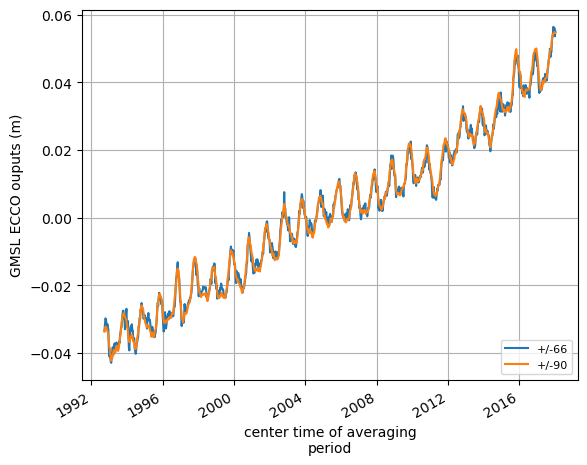

In [22]:
fig=plt.figure()
(ECCO_global_mean_sea_level.gmsl_ecco).plot(label='+/-66');
(ECCO_global_mean_sea_level_all.gmsl_ecco).plot(label='+/-90');
plt.grid()
plt.ylabel('GMSL ECCO ouputs (m)')
plt.legend(ncol=1, loc='lower right',fontsize=8)
# plt.savefig(fig_dir / 'GMSL_ecco_output_66_alllat_nosicapplied.png',dpi=200,transparent=False,facecolor='white')

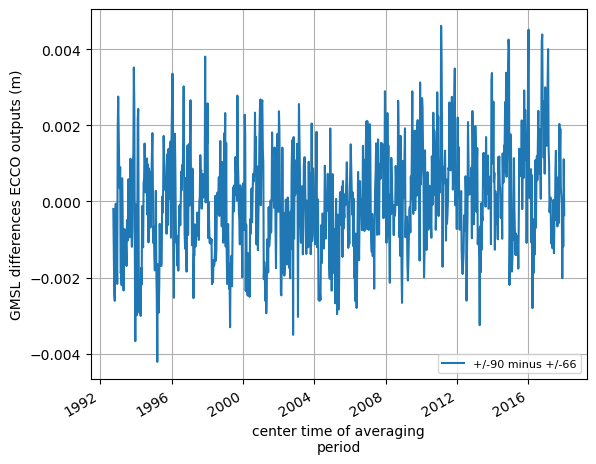

In [23]:
fig=plt.figure()
(ECCO_global_mean_sea_level_all.gmsl_ecco-ECCO_global_mean_sea_level.gmsl_ecco).plot(label='+/-90 minus +/-66')
plt.grid()
plt.title('')
plt.ylabel('GMSL differences ECCO outputs (m)')
plt.legend(ncol=2, loc='lower right',fontsize=8)
# plt.savefig(fig_dir / 'GMSL_ecco_output_66minusalllat_nosicapplied2.png',dpi=200,transparent=False,facecolor='white')

### Zonal plots

In [ ]:
ECCO_global_mean_sea_level_zonal_all = (ECCO_SSH_all * ECCO_ocean_area_all).sum(dim=['longitude'],skipna=True)/ECCO_total_ocean_area_zonal_all
ECCO_global_mean_sea_level_zonal_all = ECCO_global_mean_sea_level_zonal_all.compute()
ECCO_global_mean_sea_level_zonal_all
ECCO_global_mean_sea_level_zonal = (ECCO_SSH * ECCO_ocean_area).sum(dim=['longitude'],skipna=True)/ECCO_total_ocean_area_zonal
ECCO_global_mean_sea_level_zonal = ECCO_global_mean_sea_level_zonal.compute()

In [ ]:
(ECCO_global_mean_sea_level_zonal_all).plot();
plt.grid()
plt.ylabel('zonal GMSL (m)')

In [ ]:
(ECCO_global_mean_sea_level_zonal).plot();
plt.grid()
plt.ylabel('zonal GMSL (m)')

In [ ]:
ECCO_global_slope_mean_sea_level_zonal=ECCO_global_mean_sea_level_zonal.polyfit(dim='time', deg=1, skipna=True, rcond=None, w=None, full=False, cov=False)
ECCO_global_slope_mean_sea_level_zonal

In [ ]:
(ECCO_global_slope_mean_sea_level_zonal.polyfit_coefficients[0,:]).plot();
plt.grid()
plt.ylabel('GMSL slope (m)')
plt.xlabel('Latitude')
# fname = output_dir / ('temp.nc')
# ECCO_global_mean_sea_level_zonal.to_netcdf(fname)

### Variance ECCO GMSL

In [ ]:
(ECCO_SSH.var(dim=('latitude','longitude'),skipna=True)).plot(label='+-66');
(ECCO_SSH_all.var(dim=('latitude','longitude'),skipna=True)).plot(label='+-90');
plt.grid()
plt.ylabel('var GMSL (m)')
plt.legend(ncol=2, loc='lower right',fontsize=8)

In [ ]:
((ECCO_SSH.var(dim=('latitude','longitude'),skipna=True))-(ECCO_SSH.var(dim=('latitude','longitude'),skipna=True)).mean()).plot(label='+-66');
((ECCO_SSH_all.var(dim=('latitude','longitude'),skipna=True))-(ECCO_SSH_all.var(dim=('latitude','longitude'),skipna=True)).mean()).plot(label='+-90');
plt.grid()
plt.ylabel('var GMSL - mean (m)')
plt.legend(ncol=2, loc='lower right',fontsize=8)